<a href="https://colab.research.google.com/github/MeiravFProject/Project/blob/main/Breast_Histopathology_Project_203022777.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

My name is Meirav Feldman (203022777), I am a computer science student in the Israel Open University.
I've decided my project will be in Computer Vision.

I am mostly interested in the way machine learning is improving the medical diagnosis process and accurecy, therfore I've decided to focus my project in this field. One of the most common health issues among women is breast cancer disease, and my goal is to improve the diagnosis of this illness using computer vision.



# **Overview**

Breast cancer types are divided into two main groups: the **carcinomas** and the **sarcomas**. Carcinomas arise from the epithelial component of the breast and Sarcomas arise from the stromal (connective tissue) components of the breast. Carcinomas comprise the vast majority of all breast cancers.


Within the large group of carcinomas, there are many different types of breast cancer. The first major division is between **in situ** and **invasive** carcinoma. In situ carcinoma is "pre-invasive" carcinoma that has not yet invaded the breast tissue. Invasive cancers have cancer cells that infiltrate outside of the normal breast lobules and ducts, and grow into the breast connective tissue. Invasive carcinomas have the potential to spread to other areas in the body. The most common type of breast cancer is **invasive ductal carcinoma (IDC)**.

![Progression of Cancer cells](https://media-us.amboss.com/media/thumbs/big_5cdc00f9d3db2.jpg)

The Diagnosis process of IDC usually starts with mammography and ultrasound imaging, but a biopsy is the only definite way to diagnose breast cancer. During a biopsy, the doctor removes tissues or cells from the body so they can be tested in a lab. The tissue is later examined by a pathologist using a microscope (this process is called **histopathology**) for the existance of cancer cells. If the cancer cells appear in the sample, the histopathology process helps to determine its aggressiveness and define the stage of the disease.

To assign an aggressiveness grade to a whole biopsy sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to mark the exact regions of IDC inside of the sample.

For my project I found a data set in Kaggle with Breast Histopathology images of patients with cancer cells. I will use this data to try and find the regions of IDC inside of the sample using computer vision algorithms. 


Link to the data set - https://www.kaggle.com/paultimothymooney/breast-histopathology-images





# **Retrieving the Data**

Becasue the data set I am using is very large, I will upload it to the colab straight from Kaggle.

The following are the commands to get this data set - 

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meiravfeldman","key":"5fe3234234e78fdc38cf4e2d2362caa8"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:52<00:00, 58.7MB/s]
100% 3.10G/3.10G [00:52<00:00, 63.1MB/s]


In [ ]:
! mkdir breast-histopathology-images
! unzip breast-histopathology-images.zip -d breast-histopathology-images

## **Investigating the data structure**

The first step of processing the images is to examine how the data is organized and what it contains.
According to the description in Kaggle the dataset consists of whole mount slide images of breast cancer specimens. From the specimens, patches of size 50 x 50 were extracted. Each patch’s file name is of the format: uxXyYclassC.png, where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

I will examine the structure -

In [ ]:
import os
base_path = 'breast-histopathology-images/IDC_regular_ps50_idx5'
patient_folders = os.listdir(base_path)
print(f'Name of some of the files: {patient_folders[:20]}')
print(f'Number of the files: {len(patient_folders)}')

Name of some of the files: ['15633', '16165', '10260', '12750', '10275', '12822', '12931', '10272', '10291', '14321', '12810', '12876', '12908', '16551', '12929', '9135', '12951', '9029', '9228', '8955']
Number of the files: 279


The files are actually folders with the patients id's as names. We have 279 patients in this data set.

What is in these folders? 

In [ ]:
patient_targets =  os.listdir(base_path + '/' + patient_folders[1])
print(patient_targets)

['1', '0']


In each patient folder we have 2 folders splitting the images to cancer (marked as class '1'), and not cancer (marked as class '0').

The folders contain the images.

In [ ]:
patient_files = os.listdir(base_path + '/' + patient_folders[1] + '/' + patient_targets[0])
print(f'Examples for the images name:{patient_files}')

The files' names fits the kaggle description as expected. 

In order to know what's the size of the data set, I'll check how many patches there are. 

In [ ]:
file_count = sum(len(files) for _, _, files in os.walk(base_path))
print(f'Total number of patches in the kaggle data set: {file_count}')

Total number of patches in the kaggle data set: 277524


There is a very large number of patches to be included in the image processing. Working with such large data set will take a lot of processing time and is not necessary to obtain good results.


I've decided to use only a part of the data for my project, therefore prior to the processing stage I'll re-build the data set according to the data I'll use.

In [ ]:
NUM_OF_PATIENTS = 279
project_files = patient_folders[: NUM_OF_PATIENTS]

## **Building the data frame**

I will upload all the data into a data frame.
<br> The data set will contain the patientId, the path to the images, the X and Y coordinates of the patches (so I could re-construct the entire breast tissue image) and the target label.

In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
def get_x_coordinate(path):
  return int(re.sub(r'.*_x(.*)_y.*', r'\1', path))

def get_y_coordinate(path):
  return int(re.sub(r'.*_y(.*)_class.*', r'\1', path))

In [ ]:
def build_data_set(files):
    data_rows = []
    for patient_id in files:
        class_0_dir= base_path + '/' + patient_id + '/0'
        class_1_dir = base_path + '/' + patient_id + '/1'
        class_0_files = os.listdir(class_0_dir)
        class_1_files = os.listdir(class_1_dir)

        data_rows.extend([patient_id, os.path.join(class_0_dir, fname), get_x_coordinate(fname), get_y_coordinate(fname),'0'] for fname in class_0_files)
        data_rows.extend([patient_id, os.path.join(class_1_dir, fname), get_x_coordinate(fname), get_y_coordinate(fname), '1'] for fname in class_1_files) 
   
    return data_rows

In [ ]:
data_rows= build_data_set(project_files)
eda_df = pd.DataFrame(data=data_rows[:], columns=["Id" ,"Path","X", "Y", "Target"])

# **EDA**

I want to explore the data in order to know what exactly it contains, how the images look like and what features I can expect when processing it.
<br> This will give me a better understanding on how I should work with it in order to maximize the results. 

In [ ]:
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns

### **Data distribution**

First, I will check how many patches are available from each class, and look at the distribution of the data set -

In [ ]:
def get_data_distribution():
  class_0_total = 0
  class_1_total = 0
  for patient_id in project_files:
      class_0_files = os.listdir(base_path + '/' + patient_id + '/0')
      class_1_files = os.listdir(base_path + '/' + patient_id + '/1')
  
      class_0_total += len(class_0_files)
      class_1_total += len(class_1_files)

  print(f'Total number of patches: {class_0_total + class_1_total}')       
  print(f'Number of patches in Class 0: {class_0_total}')
  print(f'Number of patches in Class 1: {class_1_total}')

In [ ]:
get_data_distribution()

Total number of patches: 277524
Number of patches in Class 0: 198738
Number of patches in Class 1: 78786


The data is not evenly distributed which is expected because for most patients the cancer tissues will take a smaller portion of the entire biopsied breast tissue. 
<br>This will be taken in consideration and be adjusted before starting the processing stage. 



### **Images size**

According to the description in kaggle, the images should be of size 50X50. I'll check if there are any images that differ from that -  

In [ ]:
from PIL import Image

def get_images_size(df):
  sizes = []
  for index in range(len(df)):
      file_path = df.Path.values[index]
      im = Image.open(file_path)
      width, height = im.size
      sizes.append([file_path, width, height])

  return pd.DataFrame(data=sizes[:], columns=["Path","Width", "Height"])

In [ ]:
REGULAR_IMAGE_SIZE = 50
images_size_df = get_images_size(eda_df)

In [ ]:
different_images_sizes = images_size_df[(images_size_df.Height != REGULAR_IMAGE_SIZE) | (images_size_df.Width != REGULAR_IMAGE_SIZE)]
print(f'Number of images with different size than 50X50: {len(different_images_sizes)}')

Number of images with different size than 50X50: 2302


Only a very small portion of the images have different size. If needed, this will be adjusted before the processing stage.

### **Exploring the images on a patient level**

First I would like to check how many patches are available per patient.


In [ ]:
def get_patients_images_count(patients_groups):
  images_per_patient_count = []
  for index in range(len(patients_groups)):
      numer_of_images = len(patients_groups[index])
      class_1_count = len(patients_groups[index][patients_groups[index].Target == '1'])
      cancer_cells_percantage = np.round(((class_1_count / numer_of_images))*100 ,2)
      images_per_patient_count.append((patients_groups[index].Id.values[0], numer_of_images, class_1_count, cancer_cells_percantage))

  return pd.DataFrame(data=images_per_patient_count, columns=["Id","Count", "Cancer_tissue_count", "Cancer_percantage"])

In [ ]:
patients_groups = [df for _, df in eda_df.groupby('Id')]

patients_images_count_df = get_patients_images_count(patients_groups)

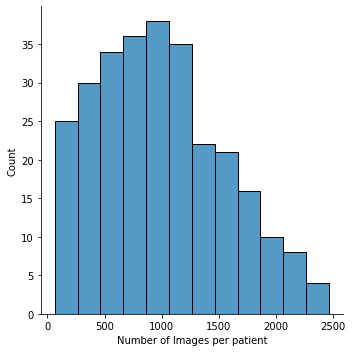

In [ ]:
x = pd.Series(patients_images_count_df.Count, name="Number of Images per patient")
sns.displot(x , binwidth=200)

Around half of the patients have between 500-1200 images, but overall the number vary greatly, meaning the biopsy size is not the same for all patients. 


I want to explore whether the size of the biopsy is correlated with the extent to which the cancer had spread.
 I assume that if the doctor suspects that the cancer is more advanced, he would like to retrieve a larger biopsy sample for examination. 
<br>In order to investigate my assumption, I will plot the number of cancerous patches, as well as the ratio between cancerous and normal patches against the number of patches retrieved for each patient. 

In [ ]:
def cancer_distribution_plot(df):
  df['Cancer_ratio'] = round(df['Cancer_tissue_count']/df['Count'],2)
  

  fig, ax = plt.subplots(1,2, figsize = (20,6), constrained_layout=False)
  ax[0].scatter(df.Count, df.Cancer_tissue_count)
  ax[0].set_xlabel('Patches_count')
  ax[0].set_ylabel('Cancer_tissue_count')
  ax[0].set_title('Cancerous Tissue Count by Number of Patches')

  ax[1].scatter(df.Count, df.Cancer_ratio)
  ax[1].set_xlabel('Patches_count')
  ax[1].set_ylabel('Cancerous_tissue_ratio')
  ax[1].set_title('Cancerous Tissue Ratio by Number of Patches')

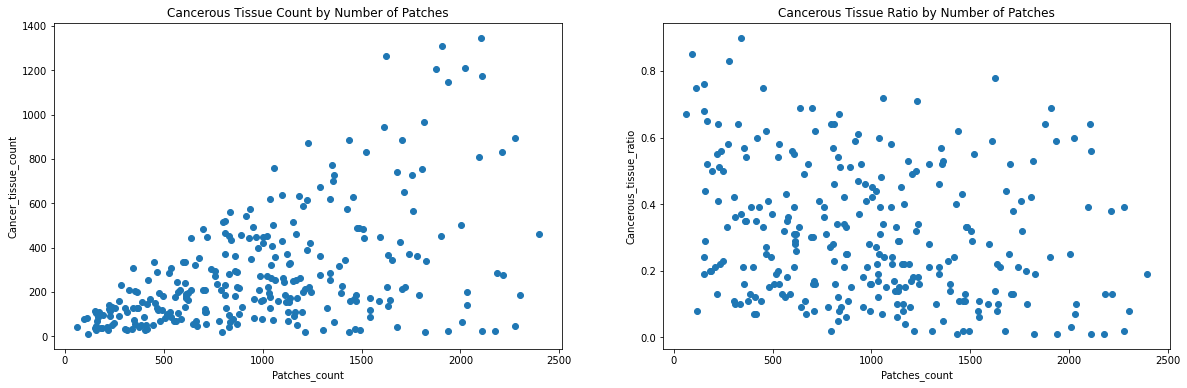

In [ ]:
cancer_distribution_plot(patients_images_count_df)

As we can see from the visualizations, there is no apparent trend for the ratio between cancerous patches and sample size.
This disputes my assumption regarding the reason for the high variability in the number of patches available for each patient. As there is no additional information regarding the patients this issue could not be investigated further. I can only assume that each doctor takes different biopsy size, and that there might be some patches that are missing for some biopsies. 

### **Visualizing the patches**

Now I want to look at a few of the images in the data set to have a better understanding of them.

In [ ]:
n_rows = 3
n_cols = 3

def create_subplots(indexes_array, title):
    fig,ax = plt.subplots(n_rows,n_cols,figsize = (5,5))
    fig.suptitle(title, fontsize=16)
    for row in range(n_rows):
        for col in range(n_cols):
            idx = indexes_array[col + n_cols*row]
            img = io.imread(eda_df.loc[idx, "Path"])
            ax[row,col].imshow(img[:,:,:])

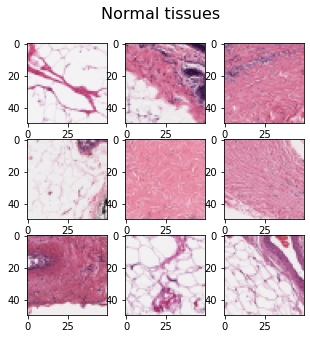

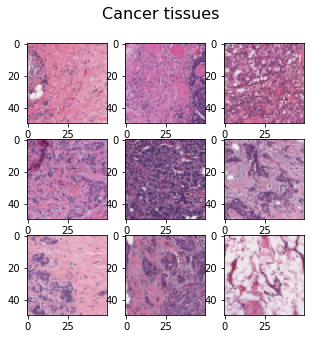

In [ ]:
negative_tissue = np.random.choice(eda_df.where(eda_df["Target"] == '0').dropna().index.values, size=9, replace=False)
positive_tissue = np.random.choice(eda_df.where(eda_df["Target"] == '1').dropna().index.values, size=9, replace=False)


create_subplots(negative_tissue, "Normal tissues")
create_subplots(positive_tissue, "Cancer tissues")


The first thing I notice when comparing the cancer and normal patches is that the normal patches has a lighter pink color and contain many white areas vs. the cancer patches that contain a darker color. 

I might get a better understanding of the differences between the categories when looking at the entire biopsy. For that, I will re-constrct it from the patches for one of the patients.

In [ ]:
def get_patient_dataframe(df, patient_id):
    return df.where(df['Id'] == patient_id).dropna()

In [ ]:
def visualise_breast_tissue(df, fig_size):
    #Build image grid
    max_point = [np.int(df.Y.max()), np.int(df.X.max())]
    grid = 250*np.ones(shape = (max_point[0] + REGULAR_IMAGE_SIZE, max_point[1] + REGULAR_IMAGE_SIZE, 3)).astype(np.uint8)
    
    for n in range(len(df)):
        try:
            image = io.imread(df.Path.values[n])
            
            x_coord = np.int(df.X.values[n])
            y_coord = np.int(df.Y.values[n])
            x_start = x_coord
            y_start = y_coord
            x_end = x_start + REGULAR_IMAGE_SIZE
            y_end = y_start + REGULAR_IMAGE_SIZE

            grid[y_start:y_end, x_start:x_end] = image

        except: pass
          #Do nothing
   
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(grid, alpha=0.9)
    ax.grid(False)
    ax.set_title(f'Breast tissue slice of patient: {EXAMPLE_PATIEND_ID}')

In [ ]:
FIGURE_SIZE = (12.5, 8.5)

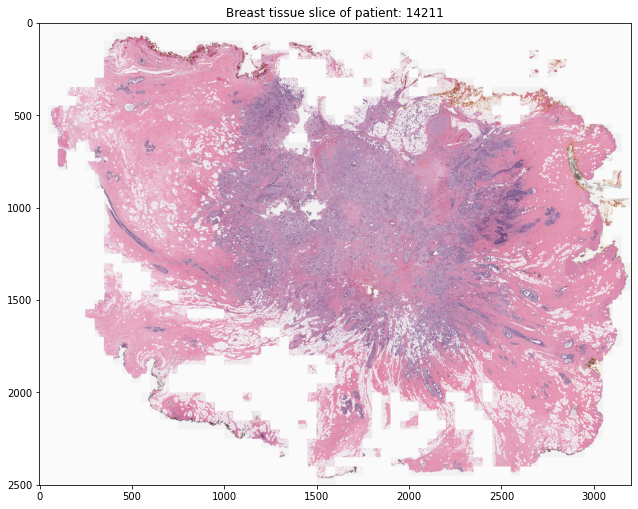

In [ ]:
EXAMPLE_PATIEND_ID = "14211"
example_biopsy_df = get_patient_dataframe(eda_df, EXAMPLE_PATIEND_ID)
visualise_breast_tissue(example_biopsy_df, FIGURE_SIZE)

First, I can see that some patches are missing from the biopsy sample (white pixels inside the image), meaning that not all the biopsy patches are included in the data set.
<br>Now, I have a better understanding of how a breast biopsy looks like. In the center of the biopsy there is a section with a different color which is probably the cancerous part (as we saw above the cancer patches are usually darker).



<br> I will plot a scatterer that will describe the cancer and non cancer patches inside the image (using the Target column), so I could confirm that.

In [ ]:
def get_target_as_Int_array(df):
  arr = []
  for i in range(len(df)):
    if df.iloc[i]["Target"] == '0':
      arr.append(0)
    else:
      arr.append(1)
  return arr

In [ ]:
def visualize_cancer_location(x_values, y_values, target, fig_size, title = ""):
    fig, ax = plt.subplots(figsize = (12.5, 8.5))
    ax.scatter(x_values, y_values, c=target, cmap = 'nipy_spectral_r', s=30);
    ax.invert_yaxis()
    ax.set_title(title + f'patient Id: {EXAMPLE_PATIEND_ID}')

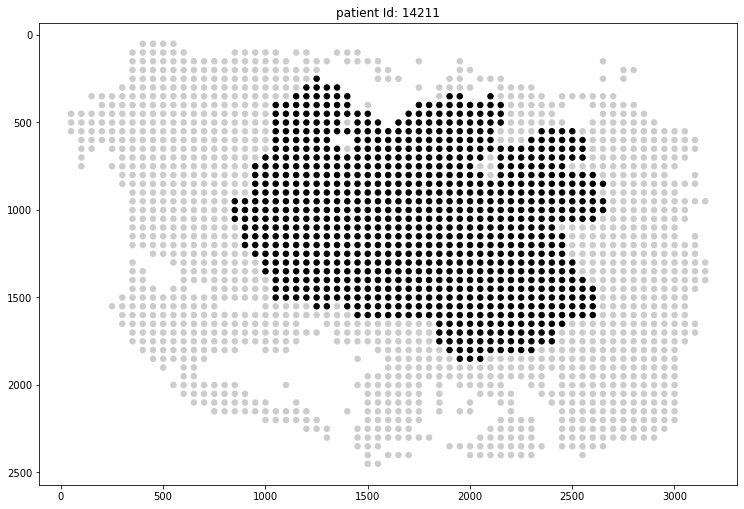

In [ ]:
target_array = get_target_as_Int_array(example_biopsy_df)
visualize_cancer_location(example_biopsy_df.X.values, example_biopsy_df.Y.values, target_array, FIGURE_SIZE)

As assumed, the dark part in the middle in the cancer cells.

Two additional features I'd like to explore are the average pixel value of an image and variability of pixels within an image, and compare the distributions of these measures between the two image groups - normal and cancer.
For that purpose, I will split the images into 2 groups by their target value, and select random images from each group.
I will then extract the pixels values from each image and compute for each image the average and varience of pixels.
Finally, I'll plot two histograms for each measure, one of the distribution of the normal images group, and the other for the cancer images group.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

NORMAL = [fn for fn in eda_df.Path[eda_df["Target"] == '0'].dropna() if fn.endswith('.png')]
CANCER = [fn for fn in eda_df.Path[eda_df["Target"] == '1'].dropna() if fn.endswith('.png')]

normal_imgs = np.random.choice(NORMAL, size=15000, replace=False)
cancer_imgs = np.random.choice(CANCER, size=15000, replace=False)

def img2np(list_of_filename, size = (REGULAR_IMAGE_SIZE, REGULAR_IMAGE_SIZE)):
    # iterating through each file
    for fn in list_of_filename:
      current_image = image.load_img(str(fn), target_size = size, 
                                       color_mode = 'grayscale')
      # covert image to a matrix
      img_ts = image.img_to_array(current_image)
      # turn that into a vector / 1D array
      img_ts = [img_ts.ravel()]
      try:
          # concatenate different images
          full_mat = np.concatenate((full_mat, img_ts))
      except UnboundLocalError: 
          # if not assigned yet, assign one
          full_mat = img_ts
    return full_mat

In [ ]:
# run it on our groupes
normal_images_mat = img2np(normal_imgs)
cancer_images_mat = img2np(cancer_imgs)

In [ ]:
def img_stat(full_mat):
    # calculate the average of an image
    mean_img = np.mean(full_mat, axis = 1)

    # calculate the varience within image
    var_img = np.var(full_mat, axis=1)

    return mean_img, var_img

In [ ]:
norm_mean, norm_var = img_stat(normal_images_mat)
cancer_mean, cancer_var = img_stat(cancer_images_mat)

def visualize_pixel_distributions(norm_mean, norm_var, cancer_mean, cancer_var):
    fig, ax = plt.subplots(1,2, figsize = (20,6), constrained_layout=False)
    bins_norm = np.arange(0, 250, 2.5)
    bins_cancer = np.arange(0, 250,2.5)
    ax[0].hist(norm_mean, bins=bins_norm ,alpha=0.5, label='Normal')
    ax[0].hist(cancer_mean, bins=bins_cancer, alpha=0.5, label='Cancer')
    ax[0].set_xlabel('Average pixel value')
    ax[0].set_ylabel('Number of images')
    ax[0].legend(loc='upper right')
    ax[0].set_title('Distribution of Average Pixel')

    bins_norm = np.arange(0, 10000, 50)
    bins_cancer = np.arange(0, 10000, 50)
    ax[1].hist(norm_var, bins=bins_norm ,alpha=0.5, label='Normal')
    ax[1].hist(cancer_var, bins=bins_cancer, alpha=0.5, label='Cancer')
    ax[1].set_xlabel('Pixel variance')
    ax[1].set_ylabel('Number of images')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Distribution of Pixel Variance Within an Image')

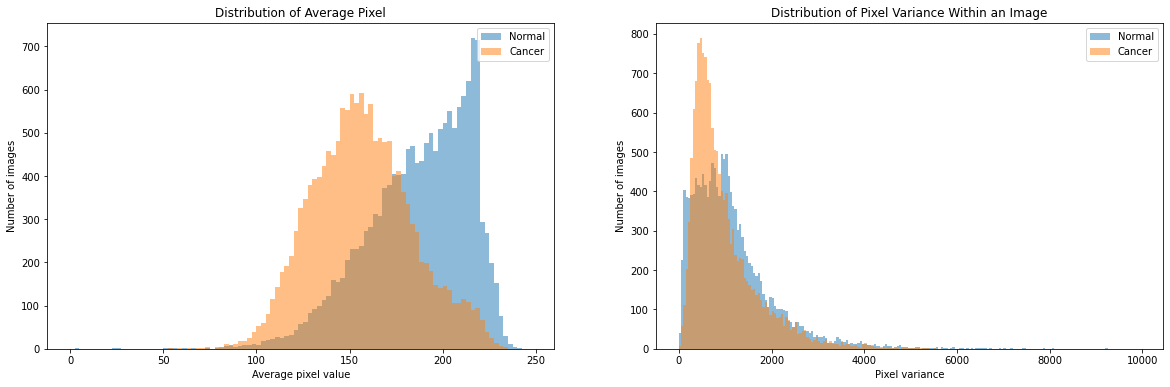

In [ ]:
visualize_pixel_distributions(norm_mean, norm_var, cancer_mean, cancer_var)

As we can see from the visualizations, the distribution of the cancer and normal groups are different. 
<br>The average pixel value in the normal group has a left tail distribution, with a peak in the top part of the pixel range. This is expected as we've seen that the normal patches are mostly light.
In contrary, the same measure in the cancer images group is normally distributed, with a lower peak pixel value, which indicates there's more content in the image. 
<br>As for the pixel variance distribution, both groups have a right tail shape distribution, with a slight difference in width and a larger (and lower) peak value in the normal group, which might indicate on greater pixel variability.

#**Constructing the data sets**
Now that I have a better understanding of the data, I can construct the data sets to be processed by my models.

As was shown above, the data set from Kaggle contains more then 250,000 images that are splitted unevenly between the 2 classification categories. 
<br>I only want to use ~50,000 images to train my models.
I might increase the sample size in more advanced stages to improve the result of the model, but this should be enough for now. 
<br> I also prefer to work with a balanced data set - why? Because when working with an unbalanced set measuring the accurecy rate is problomatic (the model can always predict the dominent class and still get fairly good results), and I will need to take a more complex approach when evaluating the accurecy of the model.  
Because I chose to use only part of the data, I can arrange it so that the train data will be splitted evenly. As for the test data, I will keep it unbalanced as it appear in the entire data set in order to mimic the real world behavior.

As part of the evaluation process of my models I wish to use one patient's biopsy sample for prediction and testing the model. I will extract all of his images as a seperate set to use at the end of the project. 

In [ ]:
patient_folders.remove(EXAMPLE_PATIEND_ID)
patient_test_data_rows= build_data_set([EXAMPLE_PATIEND_ID])
df_example_patient = pd.DataFrame(data=patient_test_data_rows[:], columns=["Id" ,"Path","X", "Y", "Target"])

I'll build the test data set from 9 patients, and by that I'll keep the classes distribution as it would be in real life. 

In [ ]:
NUM_OF_TEST_PATIENTS = 9
test_patients = patient_folders[: NUM_OF_TEST_PATIENTS]
test_data_rows= build_data_set(test_patients)
df_test = pd.DataFrame(data=test_data_rows[:], columns=["Id" ,"Path","X", "Y", "Target"])

I will now build the data set to be used in the training process. I'll randomly sample 30,000 images from each class, and combine them to a single data set. 

In [ ]:
dataset_patients_files = patient_folders[NUM_OF_TEST_PATIENTS + 2 : ]
project_data_rows= build_data_set(dataset_patients_files)
df = pd.DataFrame(data=project_data_rows[:], columns=["Id" ,"Path","X", "Y", "Target"])

In [ ]:
NUM_OF_IMAGES_EACH_CLASS = 30000

In [ ]:
def construct_data_frame(df, class0, class1):
    cancer_df = df.where(df["Target"] == "1").dropna()
    cancer_df = cancer_df.sample(n=class1)
    noncancer_df = df.where(df["Target"] == "0").dropna()
    noncancer_df = noncancer_df.sample(n=class0)
    frames = [cancer_df, noncancer_df]
    result_df = pd.concat(frames)
    result_df = result_df.reset_index()
    return result_df

In [ ]:
df = construct_data_frame(df, NUM_OF_IMAGES_EACH_CLASS, NUM_OF_IMAGES_EACH_CLASS)

Regarding the validation set that is used for the NN models, I want it to be distributed similary to the test set in order for it to describe better the accuracy of the model and improve the tuning of the model parameters.

In [ ]:
NUM_OF_IMAGES_CANCER_CLASS = 2500
NUM_OF_IMAGES_NONCANCER_CLASS = 6000

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_validation_balanced = train_test_split(df, test_size=0.2, stratify=df['Target'])

df_validation = construct_data_frame(df_validation_balanced, NUM_OF_IMAGES_NONCANCER_CLASS, NUM_OF_IMAGES_CANCER_CLASS)

In [ ]:
def get_classes_count(df):
    grp = df.groupby(['Target'])['Path'].nunique()
    return {key: grp[key] for key in grp.keys()}

In [ ]:
def get_classes_proportion(df):
    classes_counts = get_classes_count(df)
    return {(value[0], np.round(value[1] / df.shape[0],3)) for value in classes_counts.items()}

I will confirm that all the sets are distributed as expected

In [ ]:
print('Train set:')
print(f'Count: {get_classes_count(df_train)}')                            
print(f'Proportions: {get_classes_proportion(df_train)}')
print()
print('Validation set:')
print(f'Count: {get_classes_count(df_validation)}')                            
print(f'Proportions: {get_classes_proportion(df_validation)}')
print()
print('Test set:')
print(f'Count: {get_classes_count(df_test)}')                            
print(f'Proportions: {get_classes_proportion(df_test)}')
print()

Train set:
Count: {'0': 24000, '1': 24000}
Proportions: {('1', 0.5), ('0', 0.5)}

Validation set:
Count: {'0': 6000, '1': 2500}
Proportions: {('0', 0.706), ('1', 0.294)}

Test set:
Count: {'0': 7146, '1': 2352}
Proportions: {('1', 0.248), ('0', 0.752)}



#**Processing**

As I am new to the world of machine learning and image processing, I would like to explore more than one model to classify this data set.

First attempt to classify will be using SVM. I will try to use this classifier in 3 different ways:
1.  Directly on the images - I will flatten the pixels to a vector which will represent the features and this will be the input.
2. I will use PCA to extract the most important features from the image and use them as the input.
3. I will use the already trained ResNet50 CNN as the feature extractor.

Second attempt to classify will be using deep learning with CNN and ANN classifier. 
1. first I will use RestNet50 Architecture for building the CNN, and build on top of it the Dense layer to predict my classes. 
2. I will build my own CNN.



### ***Evaluation Metrics***

How will I evaluate my models?
<br>As my model is classifying whether an image contains cancer or not, it is more critical in my opinion to capture the disease rather than to misclassify normal patches as cancerous; Meaning the Positive class is more important than the Negative class. This will be taken under consideration when choosing the evaluation metrics I use:   

1. Accuracy - the ratio of correct predictions to the total predictions. 
<br>Although in this metric both classes are equally important, because my data is splitted evenly this will be a very good measure for the model. 

2. Fbeta-Measure - The F-measure balances the precision and recall scores.
<br> First, I will define what are these measurements:
<br>**Precision** = TruePositive / (TruePositive + FalsePositive) - what proportion of predicted Positives is truly Positive.
<br>**Recall** = TruePositive / (TruePositive + FalseNegative) - what proportion of actual Positives is correctly classified
<br>**Fbeta** = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall), where the balance of precision and recall is controlled by a coefficient called beta. 

  For my evaluation measure I want to increase the importance of recall over precision in order to decrease the value of false negatives. For that I will use the **F2 Measure** with a beta value of 2.0.


3. Confusion matrix - this provides insight as to which classes are being predicted correctly, which incorrectly, and what type of errors are being made.


---



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class Evaluator:
    def __init__(self, labels, rounded_predictions):
        self.labels = labels
        self.rounded_predictions = rounded_predictions

    def get_accuracy_score(self):
      return accuracy_score(self.labels, self.rounded_predictions)

    def plot_cm(self):
      cm = confusion_matrix(self.labels, self.rounded_predictions)
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix')
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

      print('(True Negatives: ', cm[0][0])
      print('False Positives: ', cm[0][1])
      print('False Negatives: ', cm[1][0])
      print('True Positives: ', cm[1][1])
      print('Total Wrong Predictions: ', np.sum(cm[1])) 

    def plot(x, y, title, xlabel, ylabel):
      plt.plot(x, y)
      plt.title(title)
      # axis labels
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      # show the legend
      plt.legend()
      # show the plot
      plt.show()

In [ ]:
class CNNEvaluator(Evaluator) :
    def __init__(self, labels, rounded_predictions, prob_predictions):
        Evaluator.__init__(self, labels, rounded_predictions)
        self.prob_predictions = prob_predictions

        self.precision, self.recall, self.thresholds = precision_recall_curve(self.labels, self.prob_predictions)

    def get_f_score(self, beta = 1):
      return fbeta_score(self.labels,  self.rounded_predictions, beta=beta)

    def plot_f2_thresholds_curve(self):
      precision_recall_dic = {'Thresholds': self.thresholds, 'Precision' : self.precision[:-1], 'Recall': self.recall[:-1] }
      precision_recall_df = pd.DataFrame(data = precision_recall_dic)
      thresholds, f2 = self.__get_f2_per_threshold(precision_recall_df)
      Evaluator.plot(thresholds, f2, "F2-Threshold", "Thresholds", "F2-Score")

    def __get_f2_per_threshold(self, df):
      f2_list = []
      for i in range(len(df)):
          f2 = self.__get_fmeasure_from_pr(df.loc[i]["Precision"], df.loc[i]["Recall"], 2)
          f2_list.append(f2)
      return (df.Thresholds, f2_list)
    
    def __get_fmeasure_from_pr(self, precision, recall, beta = 1):
        return ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)

In [ ]:
class SVMEvaluator(Evaluator) :
    def __init__(self, labels, rounded_predictions, scored_predictions):
        Evaluator.__init__(self, labels, rounded_predictions)
        self.scored_predictions = scored_predictions
        self.thresholds = np.arange(0.0,-1.0, -1.0/len(labels))

    def get_f_score(self, beta = 1):
      return fbeta_score(self.labels, self.rounded_predictions, pos_label = '1', beta=beta)
    
    def plot_f2_thresholds_curve(self):
        f2_list = []
        for threshold in self.thresholds:
          rounded_predictions_by_threshold = ['1' if (val > threshold) else '0' for val in self.scored_predictions]
          f2 = fbeta_score(self.labels,  rounded_predictions_by_threshold, pos_label = '1', beta=2)
          f2_list.append(f2)
        
        max_f2 = max(f2_list)
        threshold_pos = f2_list.index(max_f2)
        max_threshold = self.thresholds[threshold_pos]
        Evaluator.plot(self.thresholds, f2_list, "F2-Threshold", "Thresholds", "F2-Score")
        print(f'F2 max value is: {max_f2} at {max_threshold} threshold')

I will create an ImageGenerator for pre processing the images before inserting them into the CNN. I am using ResNet preprocess_input function to normalize the pixels, resizing the image and building batches of images to be processed in the CNN.

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

class ImageGenerator:

    def __init__(self, batch_size, image_size):
        self.data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
        self.batch_size = batch_size 
        self.image_size = image_size

    def generator(self, df, is_shuffle):
        generator = self.data_generator.flow_from_dataframe(
            df,
            x_col="Path",
            y_col="Target",
            target_size=(self.image_size, self.image_size),
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle = is_shuffle)
        return generator

## **Support Vector Machine Classifier**

The SVM algorithm is a supervised learning algorithm , where each data feature is plotted as a point in a n-dimensional space (where n is the number of features), with the value of each feature being the value of a particular coordinate. The classification is made by finding the hyper-plane that creates the best differentiation between the classes. 

I will use this algorhithem on features that I will extract from the image in 3 different ways, and compare the results between them.

In [ ]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import tensorflow.keras as keras

In [ ]:
svm_model = svm.SVC(kernel='rbf')

In [ ]:
def show_svm_results(labels, scored_predictions):
  rounded_predictions = ['1' if (val > 0) else '0' for val in scored_predictions]
  result = SVMEvaluator(labels, rounded_predictions, scored_predictions)
  print(f'SVM Model accurecy: {result.get_accuracy_score()}')
  print(f'SVM Model F2-Score: {result.get_f_score(2)}')
  result.plot_f2_thresholds_curve()
  result.plot_cm()

In [ ]:
IMAGE_SIZE = 32

def get_features(df):
  flat_data_arr=[] #input array
  target_arr=[] #output array

  for i in range(len(df)):
      image = io.imread(df.Path.values[i])
      img_resized=resize(image,(IMAGE_SIZE,IMAGE_SIZE,3))
      flat_data_arr.append(img_resized.flatten())
      target_arr.append(df.Target.values[i])

  features_df=pd.DataFrame(data = flat_data_arr) #dataframe

  return (features_df, target_arr)

### **First attempt**


Getting the features: 
<br>As I mentioned above, in the first attempt I will use the pixel data from each image as the features to the SVM. I will resize all images to be 32X32, meaning the number of features is: 32X32X3 = 3072.

In [ ]:
train_features, train_labels = get_features(df_train)
test_features, test_labels = get_features(df_test)

Training the model on the train set feaures:

In [ ]:
svm_model.fit(train_features,train_labels)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Predicting on the test set features:

In [ ]:
predicted_scores = svm_model.decision_function(test_features)


Evaluating the model: 

SVM Model accurecy: 0.839325943948815
SVM Model F2-Score: 0.775601964148376


No handles with labels found to put in legend.


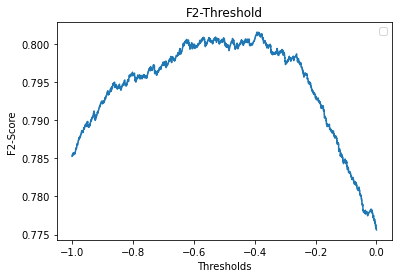

F2 max value is: 0.8015224448673458 at -0.39082634946381906 threshold
(True Negatives:  6692
False Positives:  1113
False Negatives:  670
True Positives:  2622
Total Wrong Predictions:  3292


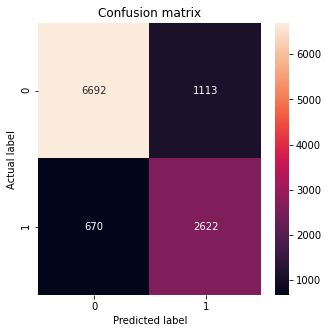

In [ ]:
show_svm_results(test_labels,predicted_scores)

The model performed pretty well. The accuracy is high and I get a good F2 result. When examining the confusion matrix, we can see that there are more false positives than false negatives, as I would prefer when predicting cancer cells.  

### **Second attempt**

The raw image contains data that isn't needed for the classification of it, and makes the learning process having to deal with more data than necessary. I want to use a feature extractor that will help me receive the most important information about the image.

In this attempt I will use PCA as the feature extractor.
PCA (Principle Component Analysis) is a dimensionality reduction technique that identifies important relationships in the data, transforms the existing data based on these relationships, and then constrcuts new features according to their importance.

I will use the features from the first attempt which are the image pixels, and perform PCA on them. I want the variance to be 95%, so I will reduce the feature number but still get valuable information. 

After applying the PCA on the original features, the feature number reduced to ~500 (from 3072)


In [ ]:
from sklearn.decomposition import PCA

feature_extractor = PCA(n_components=0.95)
train_extracted_features = feature_extractor.fit_transform(train_features)
test_extracted_features = feature_extractor.transform(test_features)

Training the mode:

In [ ]:
svm_model.fit(train_extracted_features,train_labels)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Predicting on the test set:

In [ ]:
predicted_scores = svm_model.decision_function(test_extracted_features)


Evaluating the results:

SVM Model accurecy: 0.8366225105884473
SVM Model F2-Score: 0.7730039595768572


No handles with labels found to put in legend.


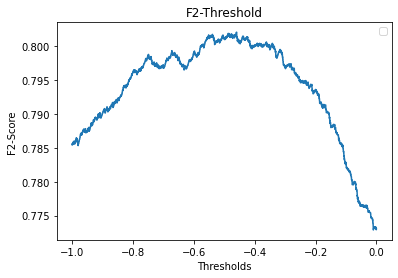

F2 max value is: 0.8020515663986693 at -0.45904298459042986 threshold
(True Negatives:  6668
False Positives:  1137
False Negatives:  676
True Positives:  2616
Total Wrong Predictions:  3292


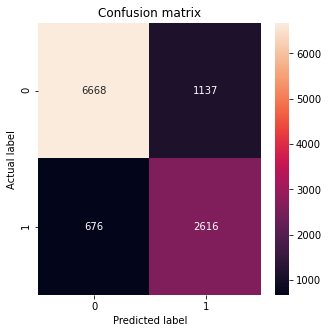

In [ ]:
show_svm_results(test_labels,predicted_scores)

There is no improvment comparing the svm with PCA and without it, but the processing time was reduced significantly when training with the PCA! (It took 3 hours to train the SVM without the PCA, and only 40 min with it). 
<br>I should keep that in mind for future work as a good way to reduce processing time without effecting the model result. 

### **Third attempt**

For the feature extractor I will use the already trained ResNet50 model, and take the features it is predicting on the images. 
ResNet50 is a variant of ResNet model which has 48 convolution layers along with 1 MaxPool and 1 Average Pool layer. The model is trained on millions of images to classify 1000 categories from the ImageNet database. The input image will propagate forward through convolutional layers, stopping at pre-specified layer, and the outputs of that layer will be taken as the features.

**Preparing images for ResNet**

Because I am using ResNet as my CNN for the feature extraction part, I need to prepare the images to fit the model. I am using Keras ImageDataGenerator class to generate the data for the model, with the ResNet50 preprocess_input function in order to prep the images as was done in this model. Then, I will generate both the train and test data using the dataFrames I've created before, and will resize the images to match the ResNet50 available input - which is a multiplication of 32.  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, AveragePooling2D, InputLayer
from keras.metrics import AUC

In [ ]:
from sklearn.utils import shuffle
BATCH_SIZE = 2**7
IMAGE_SIZE = 32

image_generator = ImageGenerator(BATCH_SIZE, IMAGE_SIZE)
df_train = shuffle(df_train)
train_generator = image_generator.generator(df_train, False)

df_test = shuffle(df_test)
test_generator = image_generator.generator(df_test, False)

Found 48000 validated image filenames belonging to 2 classes.
Found 9823 validated image filenames belonging to 2 classes.


Building the ResNet model - I am removing the last layer of the model which is the prediction layer. 

In [ ]:
NUM_OF_RESTNET_FEATURES = 2048

In [ ]:
resnet_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
resnet_output = AveragePooling2D((1, 1), name='avg_pool_app')(resnet_model.output)
resnet_model = keras.Model(resnet_model.input, resnet_output, name="ResNet")
resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________

Extracting the features using the model - 

In [ ]:
resnet_features_train = resnet_model.predict(train_generator)
resnet_features_train = np.reshape(resnet_features_train, (-1, NUM_OF_RESTNET_FEATURES))

resnet_features_test = resnet_model.predict(test_generator)
resnet_features_test = np.reshape(resnet_features_test, (-1, NUM_OF_RESTNET_FEATURES))

I will insert the ResNet extracted features into the SVM model, and then predict and examine the results on the test data.

In [ ]:
svm_model.fit(resnet_features_train,train_generator.labels)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicted_scores = svm_model.decision_function(resnet_features_test)


SVM Model accurecy: 0.8136007329736333
SVM Model F2-Score: 0.81710086042065


No handles with labels found to put in legend.


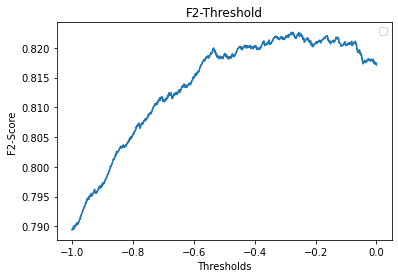

(True Negatives:  5257
False Positives:  1421
False Negatives:  410
True Positives:  2735
Total Wrong Predictions:  3145


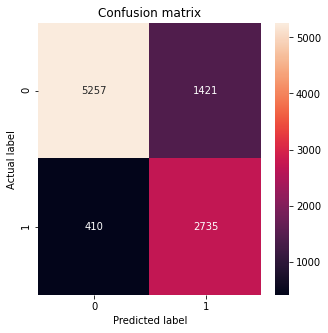

In [ ]:
test_labels_string = [str(label) for label in test_generator.labels]
show_svm_results(test_labels_string,predicted_scores)

This model performed slightly worse than the other SVM models regarding the accuracy, but it got higher F2 result. I assume that it's because the ResNet model is trained on totaly different images and extract features that maybe don't fit perfectly to this classification problem.  

##**CNN with ANN Classifier**

Convolutional Neural Networks are a category of Neural Networks that have proven very effective in areas such as image recognition and classification. The input image will propagate forward through convolutional layers in order to extract its most important features, then the features will be flatten to a 1-dim vector and a fully connected layer will be connected to the output layer giving the predictions.

![basic cnn](https://www.upgrad.com/blog/wp-content/uploads/2020/12/1-4.png)

I will build the code that I will use to evaluate the model - 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, AveragePooling2D, InputLayer, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation

In [ ]:
def show_cnn_results(labels, rounded_predictions, prob_predictions):
  result = CNNEvaluator(labels, rounded_predictions, prob_predictions)
  print(f'CNN Model accurecy: {result.get_accuracy_score()}')
  print(f'CNN Model F2-Score: {result.get_f_score()}')
  result.plot_f2_thresholds_curve()
  result.plot_cm()

In [ ]:
def plot_model_history(history):
  fig, axis = plt.subplots(1, 2, figsize=(25,10))

  axis[0].plot(history.history['accuracy'])
  axis[0].plot(history.history['val_accuracy'])
  axis[0].title.set_text('Accuracy')
  axis[0].legend(['Train', 'Validation'], loc='upper left')

  axis[1].plot(history.history['loss'])
  axis[1].plot(history.history['val_loss'])
  axis[1].title.set_text('Loss')
  axis[1].legend(['Train', 'Validation'], loc='upper right')

### **First attempt**

First I want to see how will a ResNet model architecture will perform on the data set.

I will take the model without its last layer which is the classifier layer, and add instead one dense layer with the number of categories I need. 

Because the categories of the images in the data set are very different than those of the imagenet I will train all the layers and not only the final layers, and will not use the ResNet weights, but start from a random weights configuration.

As for the model configurations, I used the 'Adam' optimizer and the categorical_crossentropy loss function, which performed the best.
<br> I trained the model with different batch size and epochs number, and for the following parameters I got the best result.

**Preparing the images**



In [ ]:
from sklearn.utils import shuffle
RESNET_BATCH_SIZE = 2**11
RESNET_IMAGE_SIZE = 32

image_generator = ImageGenerator(RESNET_BATCH_SIZE, RESNET_IMAGE_SIZE)

train_generator = image_generator.generator(df_train, True)
validation_generator = image_generator.generator(df_validation, True)
df_test = shuffle(df_test)
test_generator = image_generator.generator(df_test, False)

Found 48000 validated image filenames belonging to 2 classes.
Found 8500 validated image filenames belonging to 2 classes.
Found 9498 validated image filenames belonging to 2 classes.


 **Building the Model**

In [ ]:
tf.keras.backend.clear_session()
NUM_CLASSES = 2

resnet_model = Sequential()
resnet_model.add(InputLayer(input_shape=(RESNET_IMAGE_SIZE,RESNET_IMAGE_SIZE,3)))
resnet_model.add(ResNet50(include_top=False, pooling='avg', weights=None))
#Define that the resnet layers are trainable
resnet_model.layers[0].trainable = True
#Add a dense layer to create the prediction layer of the model
resnet_model.add(Dense(NUM_CLASSES, activation='softmax'))


resnet_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

resnet_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


**Training the model**

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(df_train) / RESNET_BATCH_SIZE)
VALIDATION_STEPS_PER_EPOCH = np.ceil(len(df_validation) / RESNET_BATCH_SIZE)

In [ ]:
history_resnet = resnet_model.fit(train_generator,
                          epochs=30, steps_per_epoch=STEPS_PER_EPOCH, 
                          validation_data=validation_generator,
                          validation_steps=VALIDATION_STEPS_PER_EPOCH, verbose=2)

Epoch 1/30
24/24 - 102s - loss: 0.9521 - accuracy: 0.7319 - val_loss: 52.6735 - val_accuracy: 0.2941
Epoch 2/30
24/24 - 26s - loss: 0.4154 - accuracy: 0.8181 - val_loss: 0.9730 - val_accuracy: 0.7941
Epoch 3/30
24/24 - 25s - loss: 0.3808 - accuracy: 0.8388 - val_loss: 0.6249 - val_accuracy: 0.6432
Epoch 4/30
24/24 - 24s - loss: 0.3280 - accuracy: 0.8646 - val_loss: 0.7147 - val_accuracy: 0.4602
Epoch 5/30
24/24 - 24s - loss: 0.3416 - accuracy: 0.8610 - val_loss: 0.7391 - val_accuracy: 0.5440
Epoch 6/30
24/24 - 24s - loss: 0.2681 - accuracy: 0.8912 - val_loss: 0.8698 - val_accuracy: 0.5062
Epoch 7/30
24/24 - 24s - loss: 0.2333 - accuracy: 0.9075 - val_loss: 1.1070 - val_accuracy: 0.4316
Epoch 8/30
24/24 - 25s - loss: 0.2153 - accuracy: 0.9119 - val_loss: 1.0754 - val_accuracy: 0.5249
Epoch 9/30
24/24 - 25s - loss: 0.1856 - accuracy: 0.9250 - val_loss: 0.7809 - val_accuracy: 0.6921
Epoch 10/30
24/24 - 24s - loss: 0.1800 - accuracy: 0.9271 - val_loss: 1.3262 - val_accuracy: 0.5302
Epoch 1

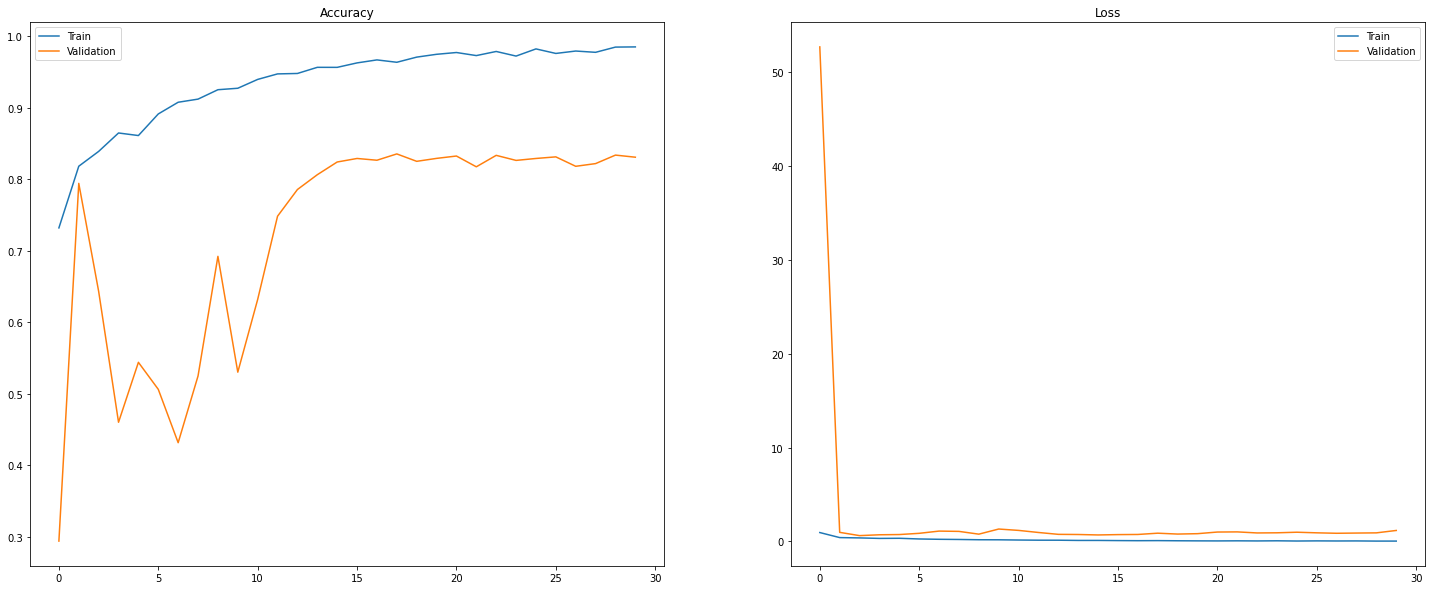

In [ ]:
plot_model_history(history_resnet)

**Predicting**

I will let the model predict on the test set, and will examine the results with my evaluation metrices.

In [ ]:
resnet_predictions = resnet_model.predict(test_generator)
resnet_rounded_predictions=np.argmax(resnet_predictions, axis=1)

**Evaluating the results**

In [ ]:
resnet_model.evaluate(test_generator)

5/5 [==============================] - 3s 625ms/step - loss: 1.4869 - accuracy: 0.8128


[1.4869115352630615, 0.8128026723861694]

CNN Model accurecy: 0.8128026953042746
CNN Model F2-Score: 0.5694915254237288


No handles with labels found to put in legend.


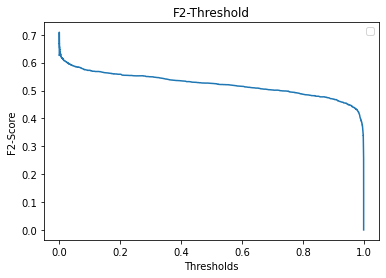

(True Negatives:  6544
False Positives:  602
False Negatives:  1176
True Positives:  1176
Total Wrong Predictions:  2352


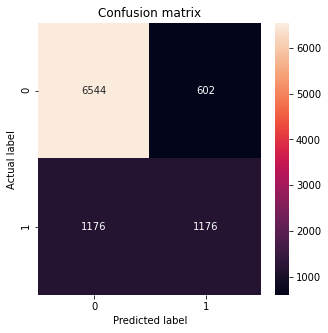

In [ ]:
show_cnn_results(test_generator.labels,resnet_rounded_predictions,resnet_predictions[:,1])

The accuracy of the model is good, we can see in the history that in increases as the epochs progress, and then converges arround 0.8. On the other hand, the F2 score is very low comparing to the other models I've tested. This is supported by the confustion matrix result, where we get more false negatives than false positives, which it the exact opposite to what I desire, and what we saw before. 

### **Second attempt**

In this attempt, I will build my own neural network, and check if I can get better results than the ResNet architecture for this type of classification.
<br> I've built the CNN according to a generic architecture, applying convolution layers with relu activation and max pooling layer on top of each other. I've added the batch normalization layers in order to decrease the number of training epochs required, and dropout layers to reduce overfitting.
<br>I've  played with the number of layers, kernel size and number of filters for each convolution layer, and the following had the best result I had achieved. 

**Prepering the images**

In [ ]:
BATCH_SIZE = 2**10
IMAGE_SIZE = 50

image_generator = ImageGenerator(BATCH_SIZE, IMAGE_SIZE)

train_generator = image_generator.generator(df_train, True)
validation_generator = image_generator.generator(df_validation, True)
df_test = shuffle(df_test)
test_generator = image_generator.generator(df_test, False)

Found 48000 validated image filenames belonging to 2 classes.
Found 8500 validated image filenames belonging to 2 classes.
Found 9498 validated image filenames belonging to 2 classes.


**Building the model**

In [ ]:
tf.keras.backend.clear_session()
NUM_CLASSES=2

my_model = Sequential()
my_model.add(Conv2D(16, (5, 5), padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(32, (5, 5), padding='same'))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Conv2D(32, (5, 5), padding='same'))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(64, (5, 5), padding='same'))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Conv2D(64, (5, 5), padding='same'))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(86, (5, 5), padding='same'))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Conv2D(86, (5, 5), padding='same'))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.25))


my_model.add(Flatten())
my_model.add(Dense(774))
my_model.add(Dropout(0.5))
my_model.add(Dense(NUM_CLASSES, activation='softmax'))

my_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 32)        0

This CNN have significantly less layers and parameters than the ResNet, but this might be enough for this type of classification.

**Training**

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(df_train) / BATCH_SIZE)
VALIDATION_STEPS_PER_EPOCH = np.ceil(len(df_validation) / BATCH_SIZE)

In [ ]:
my_model_history = my_model.fit(train_generator,
                          epochs=24, steps_per_epoch=STEPS_PER_EPOCH, 
                          validation_data=validation_generator,
                          validation_steps=VALIDATION_STEPS_PER_EPOCH, verbose=2)

Epoch 1/24
47/47 - 24s - loss: 1.1422 - accuracy: 0.6939 - val_loss: 27.9279 - val_accuracy: 0.7120
Epoch 2/24
47/47 - 19s - loss: 0.4705 - accuracy: 0.7984 - val_loss: 12.8742 - val_accuracy: 0.7240
Epoch 3/24
47/47 - 19s - loss: 0.4471 - accuracy: 0.8104 - val_loss: 6.4169 - val_accuracy: 0.7102
Epoch 4/24
47/47 - 20s - loss: 0.4270 - accuracy: 0.8206 - val_loss: 3.3038 - val_accuracy: 0.7099
Epoch 5/24
47/47 - 19s - loss: 0.4045 - accuracy: 0.8292 - val_loss: 1.0168 - val_accuracy: 0.7751
Epoch 6/24
47/47 - 19s - loss: 0.3891 - accuracy: 0.8359 - val_loss: 0.6676 - val_accuracy: 0.8138
Epoch 7/24
47/47 - 21s - loss: 0.3778 - accuracy: 0.8397 - val_loss: 0.4775 - val_accuracy: 0.7969
Epoch 8/24
47/47 - 20s - loss: 0.3707 - accuracy: 0.8415 - val_loss: 0.5976 - val_accuracy: 0.6787
Epoch 9/24
47/47 - 19s - loss: 0.3623 - accuracy: 0.8469 - val_loss: 0.6270 - val_accuracy: 0.6614
Epoch 10/24
47/47 - 20s - loss: 0.3583 - accuracy: 0.8493 - val_loss: 0.9974 - val_accuracy: 0.4538
Epoch 1

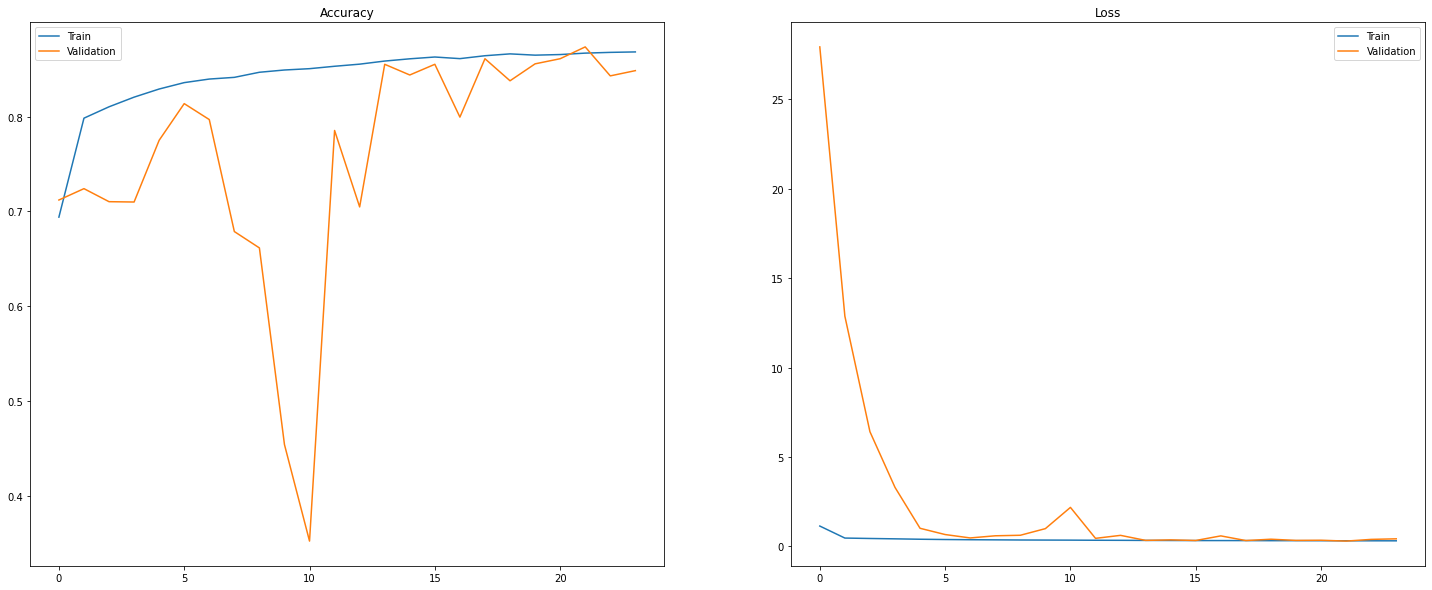

In [ ]:
plot_model_history(my_model_history)

**Predicting**

In [ ]:
prob_predictions = my_model.predict(test_generator)
rounded_predictions=np.argmax(prob_predictions, axis=1)

**Evaluating**

In [ ]:
my_model.evaluate(test_generator)

10/10 [==============================] - 4s 346ms/step - loss: 0.4880 - accuracy: 0.8442


[0.488038033246994, 0.8441777229309082]

CNN Model accurecy: 0.8441777216256053
CNN Model F2-Score: 0.6482889733840304


No handles with labels found to put in legend.


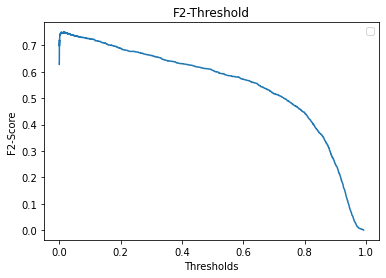

(True Negatives:  6654
False Positives:  492
False Negatives:  988
True Positives:  1364
Total Wrong Predictions:  2352


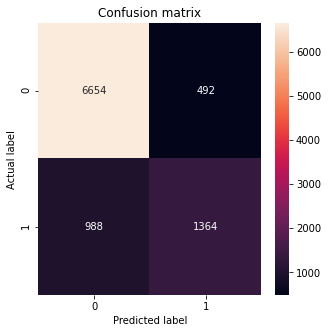

In [ ]:
show_cnn_results(test_generator.labels,rounded_predictions,prob_predictions[:,1])

This architecutre actually performed a little better than the ResNet on this data set. The accuracy improved a bit, and when playing with the parameters I got at some point even better result, but I didn't successed to re-produce it. I believe that with small changes to the model I can improve the result even more.
<br> The F2 score is still very low. 

# **Evaluating on a Patient file**

Now I would like to use the best model I trained from each classifier in order to try and find the cancer location on the full biopsy sample of my example patient.
This procedure will imitate how I would like the model to be used by doctors to help them know which area to focus on when trying to decide how progresive the cancer is.

In [ ]:
def plot_evaluation_results(df_example_patient_prediction_cancer):
    df_example_patient_actual_normal = df_example_patient.where(df_example_patient['Target'] == '0').dropna()
    df_example_patient_actual_cancer = df_example_patient.where(df_example_patient['Target'] == '1').dropna()

    ig, ax = plt.subplots(figsize = (18,12))
    label_normal = ax.scatter(df_example_patient_actual_normal.X.values, df_example_patient_actual_normal.Y.values, c= 'y', s=50, alpha=0.3);
    label_cancer = ax.scatter(df_example_patient_actual_cancer.X.values, df_example_patient_actual_cancer.Y.values, c= 'c', s=50, alpha=0.4);
    prediction_cancer = ax.scatter(df_example_patient_prediction_cancer.X.values, df_example_patient_prediction_cancer.Y.values, c='r', s=50, alpha=0.3);
    ax.invert_yaxis()


    ax.legend((label_normal, label_cancer, prediction_cancer),
              ('Normal patch', 'Cancer patch', 'Predicted cancer patch'),
              scatterpoints=1,
              loc='lower left',
              ncol=3,
              fontsize=10)
    ax.set_title(f'patient Id: {EXAMPLE_PATIEND_ID}')

### **Using SVM classifier**
The best result using the svm classifier came from the second attempt using the PCA as feature extractor (it is faster than the first attemp, and got better results than the ResNet feature extractor)
<br> I will use the model from the first try to evaluate on the patient:

In [ ]:
example_patient_features, example_patient_labels = get_features(df_example_patient)
example_patient_features = feature_extractor.fit_transform(example_patient_features)

In [ ]:
example_patient_svm_predicted_scores = svm_model.decision_function(example_patient_features)
example_patient_svm_rounded_predictions = [1 if (val > -0.45) else 0 for val in example_patient_svm_predicted_scores]

In [ ]:
df_example_patient['SVMPredicatedTarget'] = example_patient_svm_rounded_predictions
df_example_patient_svm_prediction_cancer = df_example_patient.where(df_example_patient['SVMPredicatedTarget'] == 1).dropna()

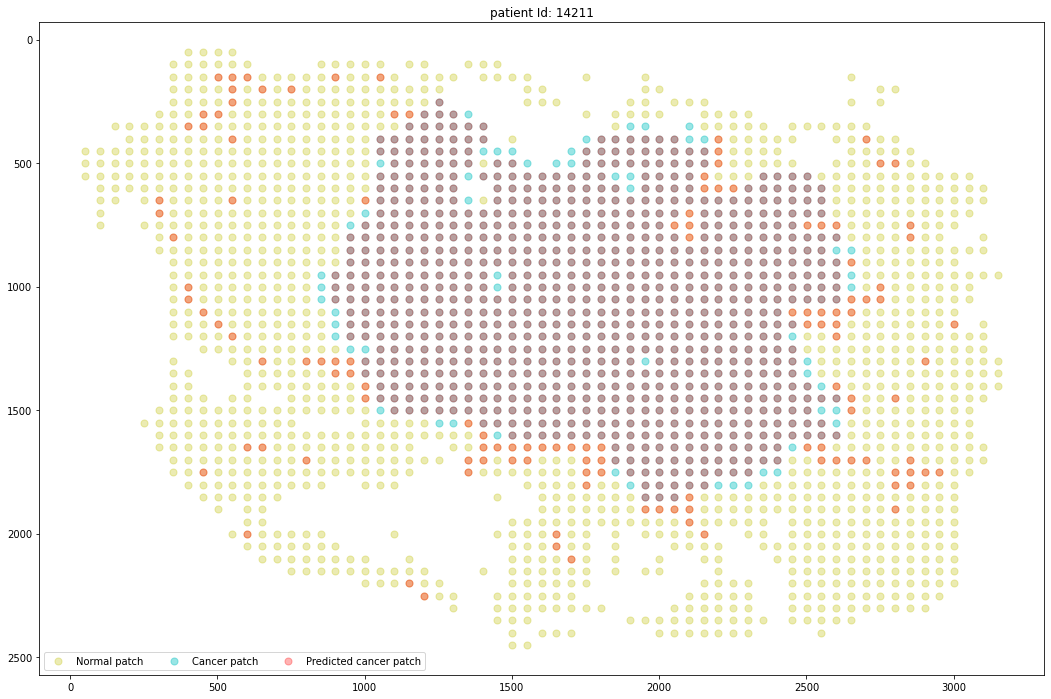

In [ ]:
plot_evaluation_results(df_example_patient_svm_prediction_cancer)

The dark patches in the image are cancer cells that were predicted as cancer.
<br>The light blue indicates that these are cancer cells that were predicted as normal cells.
<br>The red cells are the ones that the model predicted as cancer, but are normal.
<br>The yellow are the cells that are normal and were predicted as so.

The prediction on the patient is pretty good! Most of the cancer cells are predicted correctly, and we can see a clear location of where the cancer is. The majotiry of errors comes from the cancer edges that are not predicted correctly. 

### **Using NN classifier**

In [ ]:
image_generator = ImageGenerator(BATCH_SIZE, IMAGE_SIZE)

df_example_patient = shuffle(df_example_patient)
example_patient_generator = image_generator.generator(df_example_patient, False)

Found 2096 validated image filenames belonging to 2 classes.


In [ ]:
example_patient_nn_prediction = my_model.predict(example_patient_generator)
example_patient_nn_rounded_predictions=np.argmax(example_patient_nn_prediction, axis=1)

In [ ]:
df_example_patient['NNPredictedTarget'] = example_patient_nn_rounded_predictions
df_example_patient_nn_prediction_cancer = df_example_patient.where(df_example_patient['NNPredictedTarget'] == 1).dropna()

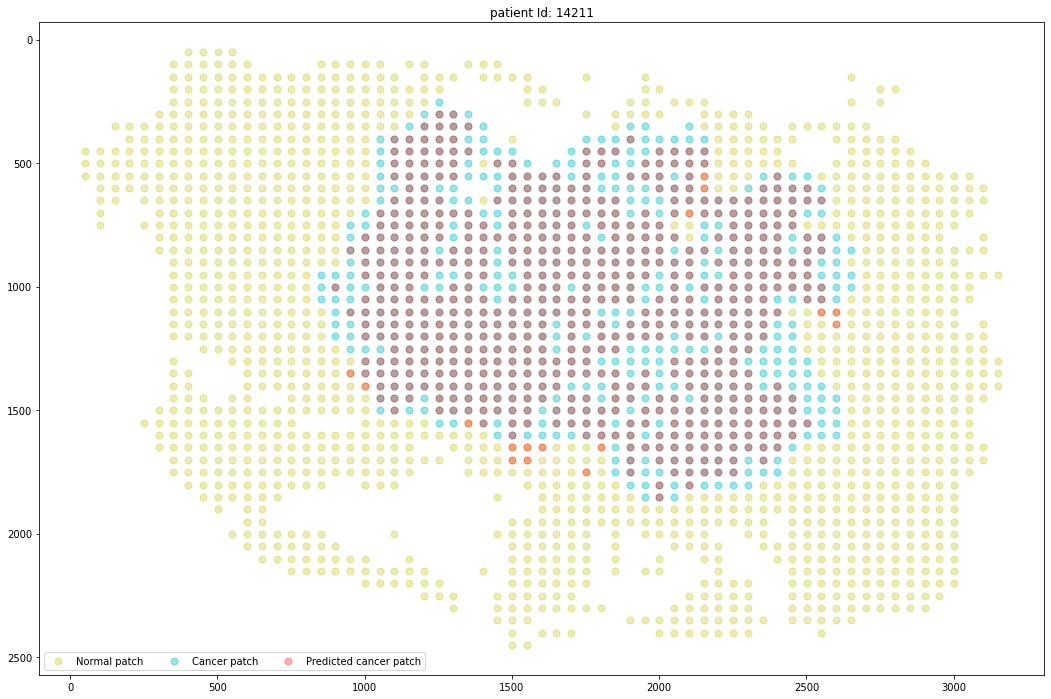

In [ ]:
plot_evaluation_results(df_example_patient_nn_prediction_cancer)

This model also have good results in predicting the patient cancer, but we can see that is has a lot more false negatives and barely have false positives, as expected from looking at the F2 score.

When comparing both results, it is clear that the SVM performed better for my goal, as it has less mistakes when predicting on the cancer patches.

# **Results**

|                | SVM | PCA + SVM | ResNet + SVM | ResNet + NN | CNN | |
|----------------|---------------|-------------|-------------|-----------|-------------|---------------|
| **Accuracy** | 0.8393       | 0.8366      | 0.8136     | 0.8128    | 0.8441      |
| **F2 Scrore**     | 0.7756            | 0.7730        | 0.8171          | 0.5694        | 0.6482        |
| **Training Time**     | ~3h            | ~40m        | ~2.5h          | ~30m        | ~30m        |

<br>

* **SVM with no additional feature extractor**  
Performed very well in terms of accuracy and F2 score, but it was very slow to train. 

* **SVM with PCA**  
Had similar results to the simple SVM but trained very quickly comparing to it.  

* **SVM with ResNet feature extractor**  
Slightly less successful than the other 2 SVM models, probably because the features that are extracted doesn't match so well to the data set images. In addition, it extracted many features so it took a lot of time to train.

* **CNN with ResNet architecure**  
In terms of accuracy, the results were similar to the SVM with ResNet feature extractor, but it had very bad F2 score results. With the help of extra gpu from colab it took very little time to train. 

* **CNN with my architecure**  
Achieved the best accuracy, but had bad F2 score results. 


 



## **Discussion**
**SVM Model**

In terms of reaching my goal to get high F2 score, the SVM classifier using the PCA as feature extractor performed the best and we can see very good results when evaluting on the example patient biopsy. 
<br>Although from what I have read it is very common to normalize the pixel value before extracting the features, on my data set it resulted in worse scores, so I didn't use it. 
<br>I think that the results can be improved by playing around with the SVM parameters such as C and Gamma, but I couldn't find any rule of thumb on how to decide how to change them, so I guess its a trying game. 


**<br>CNN Model**

For the current models I chose, in order to improve the F2 score, I can try to insert the F2-score metrics into the training process, and it might result in better parameter tuning to get better scores.
<br>From reading on deep learning I think that with greater knowledge and hands on experience I could significantly improve the model's results. There is a very large spectrum of architectures and ways to construct the layers, and a lot of different approaches on how to tune the parameters, and I believe that if I had continue to play with it and really understand how they are effecting the result, there would be an improvement.

# **Retrospective**

I've had a lot of fun working on this project mainly because of the problem I chose to tackle, and I believe that getting good results for it can make a big difference; It can reduce the time that physicians spend on interpreting such images and help them concentrate on building the treatment methods. It can also reduce human mistakes in wrongly diagnosing the disease progression.

In addition, It was very interesting reading and learning about deep learning methods, which introduced big improvements in the image processing field. 

From this project I have experienced the great power of image processing algorithms that performed very well on this data set. I was very pleased to see how the good model results manifested when evaluating on the example patient.